#Milestone 4 - Demo Code

#Water Potability

Link to Kaggle dataset: https://www.kaggle.com/datasets/adityakadiwal/water-potability

## Import and Load

In [ ]:
# import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, log_loss
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK, space_eval

In [ ]:
# load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/GHcpv24/DS675_Milestone4/main/water_potability.csv")

# or
# !wget -q https://raw.githubusercontent.com/GHcpv24/DS675_Milestone4/main/water_potability.csv
# df = pd.read_csv("water_potability.csv")

##EDA

In [ ]:
# print dimensions
df.shape

(3276, 10)

In [ ]:
# print summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
# preview the first 5 rows of the dataset 
df.head(n=5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# find NULL values
df.isna().sum().sort_values(ascending = False)

Sulfate            781
ph                 491
Trihalomethanes    162
Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
Potability           0
dtype: int64

In [ ]:
# print summary statistics rounded to 5 decimal places
df.describe().round(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.00000,3276.00000,3276.00000,3276.00000,2495.00000,3276.00000,3276.00000,3114.00000,3276.00000,3276.00000
mean,7.08079,196.36950,22014.09253,7.12228,333.77578,426.20511,14.28497,66.39629,3.96679,0.39011
std,1.59432,32.87976,8768.57083,1.58308,41.41684,80.82406,3.30816,16.17501,0.78038,0.48785
min,0.00000,47.43200,320.94261,0.35200,129.00000,181.48375,2.20000,0.73800,1.45000,0.00000
25%,6.09309,176.85054,15666.69030,6.12742,307.69950,365.73441,12.06580,55.84454,3.43971,0.00000
50%,7.03675,196.96763,20927.83361,7.13030,333.07355,421.88497,14.21834,66.62249,3.95503,0.00000
75%,8.06207,216.66746,27332.76213,8.11489,359.95017,481.79230,16.55765,77.33747,4.50032,1.00000
max,14.00000,323.12400,61227.19601,13.12700,481.03064,753.34262,28.30000,124.00000,6.73900,1.00000


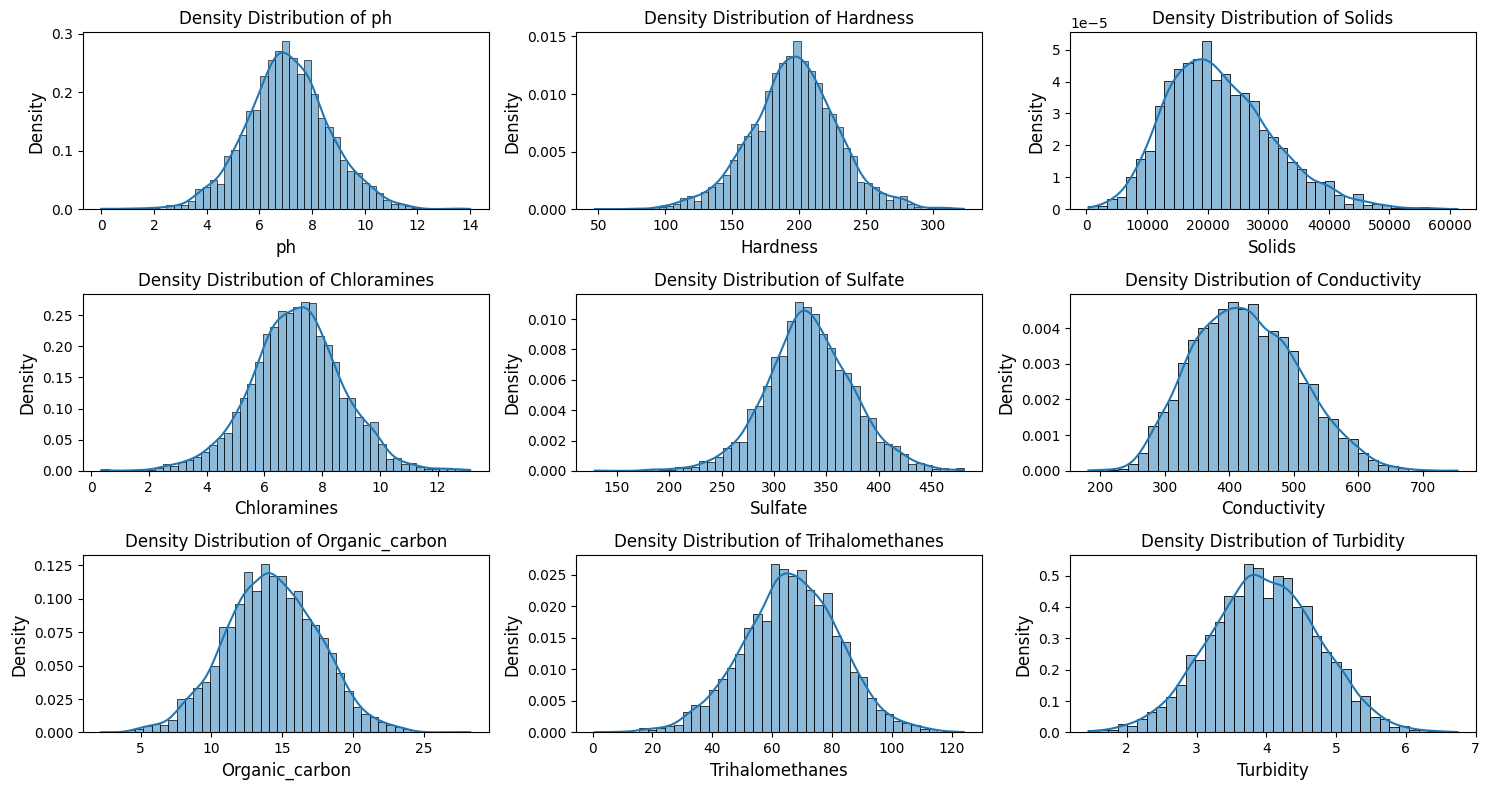

In [ ]:
# plot distributions of each feature
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,8))
axs = axs.flatten()

for i, col in enumerate(df.columns[:-1]):
    sns.histplot(data=df, x=col, ax=axs[i], kde=True, stat='density')
    axs[i].set_xlabel(col, fontsize=12)
    axs[i].set_ylabel('Density', fontsize=12)
    axs[i].set_title(f'Density Distribution of {col}')

fig.tight_layout()
plt.show()

In [ ]:
# print for each feature count of values exceeding the safe level limit
# print how many of these values are labeled as either 0 or 1
safe_limits = {
    'ph': (6.5, 8.5),
    'Hardness': 180,
    'Solids': 500,
    'Chloramines': 4,
    'Sulfate': 250,
    'Conductivity': 1500,
    'Organic_carbon': 2,
    'Trihalomethanes': 0.08,
    'Turbidity': 4}

for feature, limit in safe_limits.items():
    if feature == 'ph':
        label0_exceeding = df[((df[feature] < limit[0]) | (df[feature] > limit[1])) & (df['Potability'] == 0)][feature].count()
        label1_exceeding = df[((df[feature] < limit[0]) | (df[feature] > limit[1])) & (df['Potability'] == 1)][feature].count()
    else:
        label0_exceeding = (df[(df[feature] > limit) & (df['Potability'] == 0)][feature] > limit).sum()
        label1_exceeding = (df[(df[feature] > limit) & (df['Potability'] == 1)][feature] > limit).sum()
    print(f"{feature}: {label0_exceeding + label1_exceeding} observations exceed the levels safe for human consumption \n {label0_exceeding} are labeled 0 (not potable) \n {label1_exceeding} are labeled 1 (potable)\n")

ph: 1457 observations exceed the levels safe for human consumption 
 939 are labeled 0 (not potable) 
 518 are labeled 1 (potable)

Hardness: 2341 observations exceed the levels safe for human consumption 
 1450 are labeled 0 (not potable) 
 891 are labeled 1 (potable)

Solids: 3275 observations exceed the levels safe for human consumption 
 1997 are labeled 0 (not potable) 
 1278 are labeled 1 (potable)

Chloramines: 3187 observations exceed the levels safe for human consumption 
 1945 are labeled 0 (not potable) 
 1242 are labeled 1 (potable)

Sulfate: 2437 observations exceed the levels safe for human consumption 
 1492 are labeled 0 (not potable) 
 945 are labeled 1 (potable)

Conductivity: 0 observations exceed the levels safe for human consumption 
 0 are labeled 0 (not potable) 
 0 are labeled 1 (potable)

Organic_carbon: 3276 observations exceed the levels safe for human consumption 
 1998 are labeled 0 (not potable) 
 1278 are labeled 1 (potable)

Trihalomethanes: 3114 observa

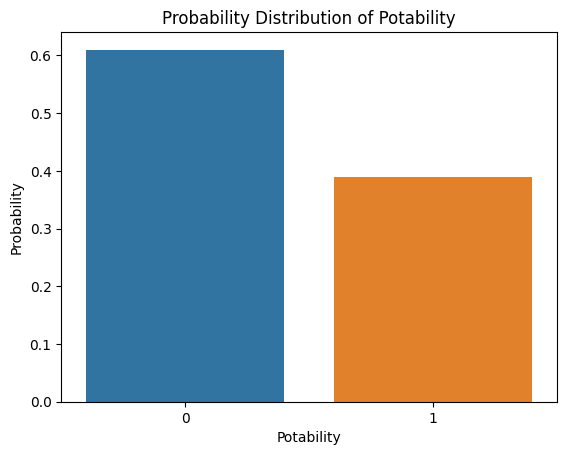

In [ ]:
#plot distribution of Potability
potability_prob = df['Potability'].value_counts(normalize=True)

sns.barplot(x=potability_prob.index, y=potability_prob.values)
plt.title('Probability Distribution of Potability')
plt.xlabel('Potability')
plt.ylabel('Probability')
plt.show()

In [ ]:
# view count of Potability values
df.Potability.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

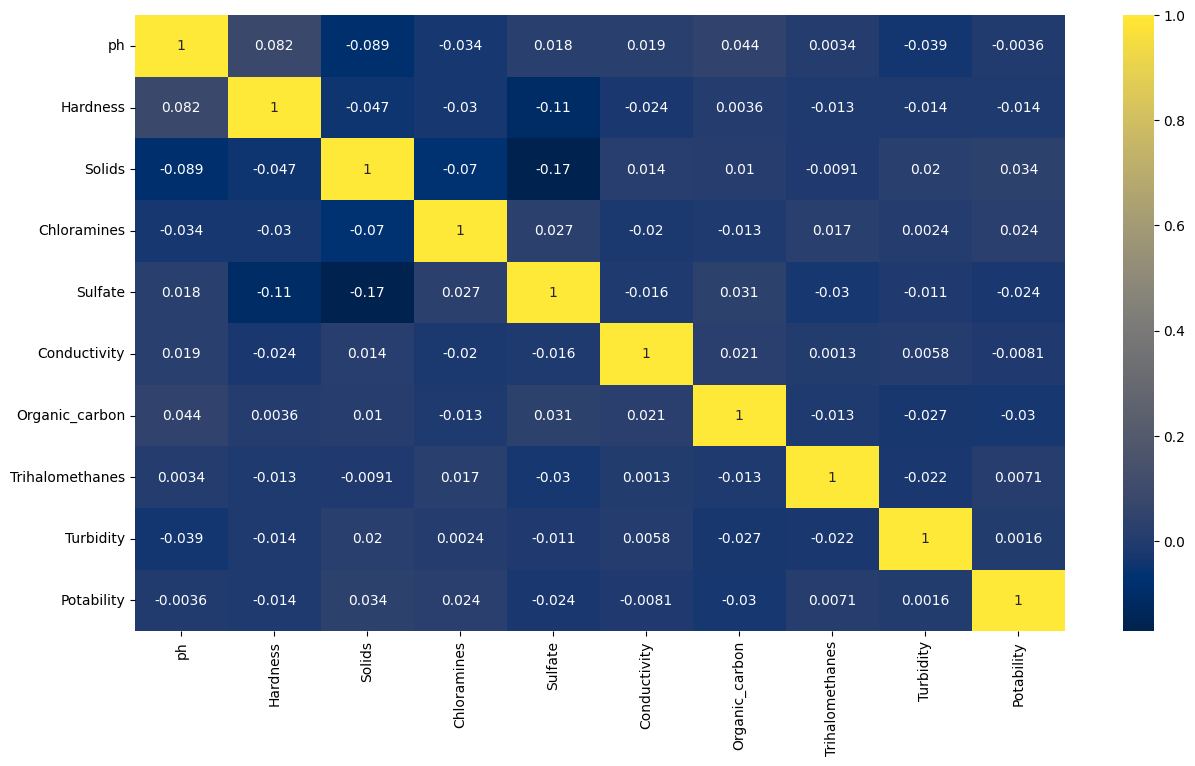

In [ ]:
# print correlation matrix
corr_matrix = df.corr()
#print(corr_matrix)

plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True, cmap='cividis')
plt.show()

In [ ]:
#print correlation of each feature to Potability
print(corr_matrix['Potability'])

ph                -0.003556
Hardness          -0.013837
Solids             0.033743
Chloramines        0.023779
Sulfate           -0.023577
Conductivity      -0.008128
Organic_carbon    -0.030001
Trihalomethanes    0.007130
Turbidity          0.001581
Potability         1.000000
Name: Potability, dtype: float64


##Data Preprocessing

###Impute

In [ ]:
# replace NULLs with averages
df = df.fillna(df.mean())

# check for NULLs
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

###Split Training and Test Sets

In [ ]:
# Target: Potability
X = df.drop(['Potability'], axis=1)
y = df['Potability']

In [ ]:
# split data into training and test sets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

###Standardize

In [ ]:
# scale all features to have mean of 0 and standard deviation of 1
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

X_train.describe().round(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2293.00000,2293.00000,2293.00000,2293.00000,2293.00000,2293.00000,2293.00000,2293.00000,2293.00000
mean,0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000
std,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022
min,-4.79909,-3.61244,-2.45269,-4.28420,-5.73837,-3.02830,-3.68647,-3.69374,-3.22925
25%,-0.54950,-0.61201,-0.72991,-0.61587,-0.45564,-0.74817,-0.67271,-0.60352,-0.66721
50%,0.00825,0.00835,-0.11812,0.02091,-0.00286,-0.03947,-0.00774,-0.01254,-0.01349
75%,0.54540,0.63455,0.59300,0.63125,0.46792,0.67961,0.69780,0.65682,0.68558
max,4.70589,3.80799,4.40885,3.68706,3.97330,4.07142,4.33126,3.62966,3.56496


##Models

### Decision Tree

The accuracy for decision tree classifier is:  0.5920651068158698
The classification report is: 
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       606
           1       0.47      0.48      0.47       377

    accuracy                           0.59       983
   macro avg       0.57      0.57      0.57       983
weighted avg       0.59      0.59      0.59       983

The confusion matrix is: 
[[401 205]
 [196 181]]


<Axes: >

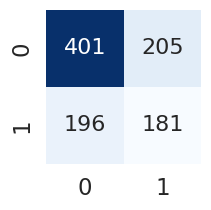

In [ ]:
dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(X_train, y_train)
dtc_preds = dtc.predict(X_test)
dtc_accuracy = accuracy_score(y_test, dtc_preds)
print("The accuracy for decision tree classifier is: ", dtc_accuracy)
print("The classification report is: ")
print(classification_report(y_test, dtc_preds))
print("The confusion matrix is: ")
print(confusion_matrix(y_test, dtc_preds))
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5) 
sns.heatmap(confusion_matrix(y_test, dtc_preds), annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

### kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
score = accuracy_score(y_test, pred_knn)
score

0.6215666327568667

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# create the model
KNN = KNeighborsClassifier(n_neighbors = 5, leaf_size =20)
# model training
KNN.fit(X_train, y_train)
# prediction
KNN_pred = KNN.predict(X_test)
# accuracy
KNN_acc = accuracy_score(y_test, KNN_pred)

In [ ]:
print("The accuracy for KNeighbors is", KNN_acc)
print("The classification report using KNeighbors is:", KNN_acc)
print(classification_report(y_test, KNN_pred))

The accuracy for KNeighbors is 0.6215666327568667
The classification report using KNeighbors is: 0.6215666327568667
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       606
           1       0.51      0.40      0.44       377

    accuracy                           0.62       983
   macro avg       0.59      0.58      0.58       983
weighted avg       0.61      0.62      0.61       983



<Axes: >

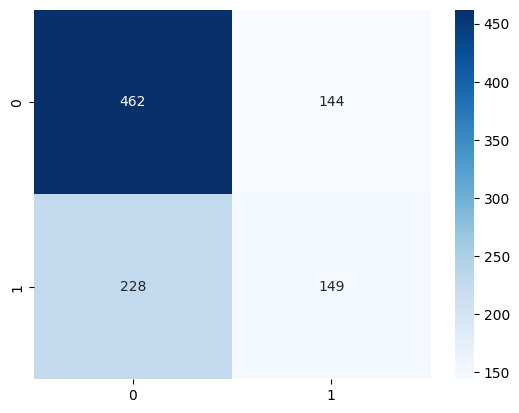

In [ ]:
#Confusion matrix
KNN_cm = confusion_matrix(y_test, KNN_pred)

#sns.heatmap(KNN_cm/np.sum(KNN_cm), annot = True, fmt = '0.2%', cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True,fmt="d" , cmap = 'Blues')

### Logistic Regression

Train Set Accuracy:60.57566506759704
Test Set Accuracy:61.74974567650051
The f1 score for the testing data: 0.005291005291005291


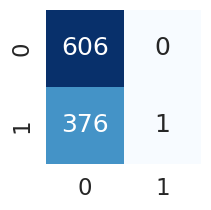

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
l1=log_reg.fit(X_train,y_train)
log_pred=l1.predict(X_test)

log_acc=accuracy_score(y_test,log_reg.predict(X_test))


print("Train Set Accuracy:"+str(accuracy_score(y_train,log_reg.predict(X_train))*100))
print("Test Set Accuracy:"+str(accuracy_score(y_test,log_reg.predict(X_test))*100))

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, log_pred)
print('The f1 score for the testing data:', f1_test)

# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(2,2))
    sns.set(font_scale=1.5) 
   
    sns.heatmap(con_mat, annot=True,  fmt='g', cmap='Blues', cbar=False)
    
#Calling function 
conf_matrix(y_test, log_pred)


Train Set Accuracy:52.551242913214125
Test Set Accuracy:49.94913530010173
conf_mat:[[315 291]
 [201 176]]
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       606
           1       0.38      0.47      0.42       377

    accuracy                           0.50       983
   macro avg       0.49      0.49      0.49       983
weighted avg       0.52      0.50      0.51       983

The f1 score for the testing data: 0.4170616113744076


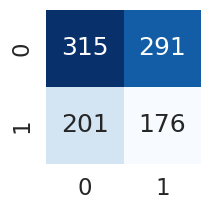

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#logistic Regression using weight Balanced
log_reg = LogisticRegression(class_weight='balanced')
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
grid_search = GridSearchCV(estimator=log_reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

#fit method
ll=grid_search.fit(X_train,y_train)
pred_log=ll.predict(X_test)
log_acc=accuracy_score(y_test,pred_log)
# train and test accuracy score 
print("Train Set Accuracy:"+str(accuracy_score(y_train,ll.predict(X_train))*100))
print("Test Set Accuracy:"+str(accuracy_score(y_test,ll.predict(X_test))*100))
print("conf_mat:"+str(confusion_matrix(y_test, pred_log)))
print(classification_report(y_test,pred_log))

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_log)
print('The f1 score for the testing data:', f1_test)

# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(2,2))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True,  fmt='g', cmap='Blues', cbar=False)
    
#Calling function 
conf_matrix(y_test, pred_log)


###SVM

In [ ]:
from sklearn.svm import SVC

# instantiate SVM classifier
svm = SVC() #kernel='rbf', random_state=123

# fit the model on training data
svm.fit(X_train, y_train)

# make predictions on test data
svm_pred = svm.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, svm_pred))

Accuracy: 0.6795523906408952


Accuracy: 0.6795523906408952
Train Set Accuracy:73.65896205843873
Test Set Accuracy:67.95523906408953
conf_mat:[[552  54]
 [261 116]]
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       606
           1       0.68      0.31      0.42       377

    accuracy                           0.68       983
   macro avg       0.68      0.61      0.60       983
weighted avg       0.68      0.68      0.64       983

The f1 score for the testing data: 0.4170616113744076


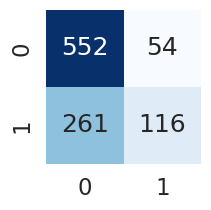

In [ ]:
from sklearn.svm import SVC

# instantiate SVM classifier
svm = SVC(kernel='rbf', random_state=123)

# fit the model on training data
svm.fit(X_train, y_train)

# make predictions on test data
svm_pred = svm.predict(X_test)
svm_acc=accuracy_score(y_test, svm_pred)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("Train Set Accuracy:"+str(accuracy_score(y_train,svm.predict(X_train))*100))
print("Test Set Accuracy:"+str(accuracy_score(y_test,svm.predict(X_test))*100))
print("conf_mat:"+str(confusion_matrix(y_test, svm_pred)))
print(classification_report(y_test,svm_pred))

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_log)
print('The f1 score for the testing data:', f1_test)

# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(2,2))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True,  fmt='g', cmap='Blues', cbar=False)
    
#Calling function 
conf_matrix(y_test, svm_pred)

###XGBoost

#### Baseline

In [ ]:
# initialize with seed=123

#start_time = time.time() # check how long training takes

# initiate XGBoost Classifier
#XGBC_basic = XGBClassifier(seed=123)

# train the model
#XGBC_basic.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

#end_time = time.time()
#elapsed_time = end_time - start_time

#hours = int(elapsed_time // 3600)
#minutes = int((elapsed_time % 3600) // 60)
#seconds = int(elapsed_time % 60)

#print("Time taken: {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

#y_pred_xgb_basic = XGBC_basic.predict(X_test)
#y_pred_proba_xgb_basic = XGBC_basic.predict_proba(X_test)[:,1]

#acc_xgb_basic = accuracy_score(y_test, y_pred_xgb_basic)
#cmreport_xgb_basic = confusion_matrix(y_test, y_pred_xgb_basic)
#clreport_xgb_basic = classification_report(y_test, y_pred_xgb_basic)
#ras_xgb_basic = roc_auc_score(y_test, y_pred_xgb_basic)
#ll_xgb_basic = log_loss(y_test, y_pred_proba_xgb_basic)

# print metrics
#print(f"\nConfusion Matrix:\n {cmreport_xgb_basic}")
#print(f"\nClassification Report:\n {clreport_xgb_basic}")
#print(f'Log loss:\n {ll_xgb_basic:.5f}')
#print(f'\nAUC score:\n {ras_xgb_basic:.5f}')
#print(f"\nAccuracy score:\n {acc_xgb_basic:.5f}") # print baseline accuracy score

In [ ]:
# set object='binary:logistic', early_stopping_rounds=10, eval_metric='logloss' and hyperparameter reg_lambda=1

start_time = time.time() # check how long training takes

# initiate XGBoost Classifier
XGBC = XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, eval_metric='logloss', seed=123, reg_lambda=1)

# train the model
XGBC.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

end_time = time.time()
elapsed_time = end_time - start_time

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print("Time taken: {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

y_pred_xgb = XGBC.predict(X_test)
y_pred_proba_xgb = XGBC.predict_proba(X_test)[:,1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
cmreport_xgb = confusion_matrix(y_test, y_pred_xgb)
clreport_xgb = classification_report(y_test, y_pred_xgb)
ras_xgb = roc_auc_score(y_test, y_pred_xgb)
ll_xgb = log_loss(y_test, y_pred_proba_xgb)

# print metrics
print(f"\nConfusion Matrix:\n {cmreport_xgb}")
print(f"\nClassification Report:\n {clreport_xgb}")
#print(f'Log loss:\n {ll_xgb:.5f}')
#print(f'\nAUC score:\n {ras_xgb:.5f}')
print(f"\nAccuracy score:\n {acc_xgb:.5f}") # print baseline accuracy score

Time taken: 0 hours, 0 minutes, and 0 seconds.

Confusion Matrix:
 [[528  78]
 [253 124]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.87      0.76       606
           1       0.61      0.33      0.43       377

    accuracy                           0.66       983
   macro avg       0.64      0.60      0.59       983
weighted avg       0.65      0.66      0.63       983


Accuracy score:
 0.66328


#### Hyperparameter Tuning

#####Grid Search

In [ ]:
# print list of parameters at default setting
XGBC.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': 10,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 123}

In [ ]:
start_time = time.time() # check how long training takes

# define a parameter grid with fewer parameters
param_grid = {'n_estimators': [10, 100, 500],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 1],
              'colsample_bytree': [0.1, 0.5, 0.9],
              'subsample': [0.1, 0.5, 0.9],
              'reg_lambda': [1, 5, 10]}
#              'reg_alpha': [1, 5, 10],
#              'gamma': [0, 0.1, 0.5],
#              'min_child_weight': [1, 3, 5]}

# k-fold cross-validation with k=5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# perform GridSearchCV
grid_search_xgb = GridSearchCV(XGBC, param_grid=param_grid, scoring = 'roc_auc', cv=kfold, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

end_time = time.time()
elapsed_time = end_time - start_time

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print("Time taken: {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

# print the best score and corresponding hyperparameters
#print(f'\nBest estimator: {grid_search_xgb.best_estimator_}')
#print(f'\nThe best score is {grid_search_xgb.best_score_:.4f}')
print(f'\nGrid Search best hyperparameters: {grid_search_xgb.best_params_}')

# get the best estimator from the grid search
grid_best = grid_search_xgb.best_estimator_

grid_pred_xgb = grid_best.predict(X_test)
grid_pred_proba_xgb = grid_best.predict_proba(X_test)[:,1]

grid_acc_xgb = accuracy_score(y_test, grid_pred_xgb)
grid_cmreport_xgb = confusion_matrix(y_test, grid_pred_xgb)
grid_clreport_xgb = classification_report(y_test, grid_pred_xgb)
grid_ras_xgb = roc_auc_score(y_test, grid_pred_xgb)
grid_ll_xgb = log_loss(y_test, grid_pred_proba_xgb)

# print metrics
print(f"\nConfusion Matrix:\n {grid_cmreport_xgb}")
print(f"\nClassification Report:\n {grid_clreport_xgb}")
#print(f'Log loss:\n {grid_ll_xgb:.5f}')
#print(f'\nAUC score:\n {grid_ras_xgb:.5f}')
print(f"\nAccuracy score:\n {grid_acc_xgb:.5f}") # print grid search accuracy score

Time taken: 0 hours, 4 minutes, and 50 seconds.

Grid Search best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'reg_lambda': 10, 'subsample': 0.9}

Confusion Matrix:
 [[533  73]
 [246 131]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.88      0.77       606
           1       0.64      0.35      0.45       377

    accuracy                           0.68       983
   macro avg       0.66      0.61      0.61       983
weighted avg       0.67      0.68      0.65       983


Accuracy score:
 0.67548


#####Random Search

In [ ]:
start_time = time.time()

# define a parameter distribution with more parameters
param_dist = {'n_estimators': [10, 100, 500],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 1],
              'colsample_bytree': [0.1, 0.5, 0.9],
              'subsample': [0.1, 0.5, 0.9],
              'reg_lambda': [1, 5, 10]}
#              'reg_alpha': [1, 5, 10],
#              'gamma': [0, 0.1, 0.5],
#              'min_child_weight': [1, 3, 5]}           

# k-fold cross-validation with k=5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# perform RandomizedSearchCV
random_search = RandomizedSearchCV(XGBC, param_distributions=param_dist, scoring = 'roc_auc', cv=kfold, n_iter=100, n_jobs=-1)

random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

end_time = time.time()
elapsed_time = end_time - start_time

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print("Time taken: {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

# print the best score and corresponding hyperparameters
#print(f'\nBest estimator: {random_search.best_estimator_}')
#print(f'\nThe best score is {random_search.best_score_:.4f}')
print(f'\nGrid Search best hyperparameters: {random_search.best_params_}')

# get the best estimator from the random search
random_search = random_search.best_estimator_

random_pred_xgb = random_search.predict(X_test)
random_pred_proba_xgb = random_search.predict_proba(X_test)[:,1]

random_acc_xgb = accuracy_score(y_test, random_pred_xgb)
random_cmreport_xgb = confusion_matrix(y_test, random_pred_xgb)
random_clreport_xgb = classification_report(y_test, random_pred_xgb)
random_ras_xgb = roc_auc_score(y_test, random_pred_xgb)
random_ll_xgb = log_loss(y_test, random_pred_proba_xgb)

# print metrics
print(f"\nConfusion Matrix:\n {random_cmreport_xgb}")
print(f"\nClassification Report:\n {random_clreport_xgb}")
#print(f'Log loss:\n {random_ll_xgb:.5f}')
#print(f'\nAUC score:\n {random_ras_xgb:.5f}')
print(f"\nAccuracy score:\n {random_acc_xgb:.5f}") # print random search accuracy score

Time taken: 0 hours, 1 minutes, and 0 seconds.

Grid Search best hyperparameters: {'subsample': 0.9, 'reg_lambda': 5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

Confusion Matrix:
 [[533  73]
 [251 126]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.88      0.77       606
           1       0.63      0.33      0.44       377

    accuracy                           0.67       983
   macro avg       0.66      0.61      0.60       983
weighted avg       0.66      0.67      0.64       983


Accuracy score:
 0.67040


#####Hyperopt

In [ ]:
start_time = time.time()

# define the search space for hyperparameters
param_space = {
    'n_estimators': hp.choice('n_estimators', [10, 100, 500]),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
    'learning_rate': hp.choice('learning_rate', [0.01, 0.1, 1]),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1, 0.5, 0.9]),
    'subsample': hp.choice('subsample', [0.1, 0.5, 0.9]),
    'reg_lambda': hp.choice('reg_lambda', [1, 5, 10]),
#    'reg_alpha': hp.choice('reg_alpha', [1, 5, 10]),
#    'gamma': hp.choice('gamma', [0, 0.1, 0.5]),
#    'min_child_weight': hp.choice('min_child_weight', [1, 3, 5])
}

# k-fold cross-validation with k=5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# define objective function to optimize
def objective(params):
    hypopt = XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, eval_metric='logloss', **params)
    hypopt.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
#    score = cross_val_score(estimator=hypopt, X=X_train, y=y_train, cv=kfold, scoring='recall', n_jobs=-1).mean()
#    loss = - score
#    return {'loss': loss, 'params': params, 'status': STATUS_OK}
    hypopt_y_pred = hypopt.predict(X_test)
    ll = log_loss(y_test, hypopt.predict_proba(X_test)[:,1])
    return {'loss': ll, 'status': STATUS_OK}

# perform hyperparameter tuning (search)
trials = Trials()
best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, trials=trials)

end_time = time.time()
elapsed_time = end_time - start_time

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print("\nTime taken: {} hours, {} minutes, and {} seconds.".format(hours, minutes, seconds))

# train the model with the best hyperparameters
best_params = space_eval(param_space, best)
XGBC_hypopt = XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, eval_metric='logloss', **best_params)
XGBC_hypopt.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

# make predictions on the test set with the best hyperparameters
hypopt_pred_xgb = XGBC_hypopt.predict(X_test)
hypopt_pred_proba_xgb = XGBC_hypopt.predict_proba(X_test)[:,1]

# calculate evaluation metrics
hypopt_acc_xgb = accuracy_score(y_test, hypopt_pred_xgb)
hypopt_cmreport_xgb = confusion_matrix(y_test, hypopt_pred_xgb)
hypopt_clreport_xgb = classification_report(y_test, hypopt_pred_xgb)
hypopt_ras_xgb = roc_auc_score(y_test, hypopt_pred_xgb)
hypopt_ll_xgb = log_loss(y_test, hypopt_pred_proba_xgb)

# best parameters
#print(f"\nIndex of best parameters: {best}")
print(f"\nValues of best parameters: {best_params}")

# print evaluation metrics
print(f"\nConfusion Matrix:\n {hypopt_cmreport_xgb}")
print(f"\nClassification Report:\n {hypopt_clreport_xgb}")
#print(f'Log loss:\n {hypopt_ll_xgb:.5f}')
#print(f'\nAUC score:\n {hypopt_ras_xgb:.5f}')
print(f"\nAccuracy score:\n {hypopt_acc_xgb:.5f}")

100%|██████████| 100/100 [00:31<00:00,  3.16trial/s, best loss: 0.6139691194237766]

Time taken: 0 hours, 0 minutes, and 31 seconds.

Values of best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 5, 'subsample': 0.9}

Confusion Matrix:
 [[539  67]
 [255 122]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.89      0.77       606
           1       0.65      0.32      0.43       377

    accuracy                           0.67       983
   macro avg       0.66      0.61      0.60       983
weighted avg       0.67      0.67      0.64       983


Accuracy score:
 0.67243


##### Comparison

In [ ]:
#xgb_basic = "XGBoost Baseline with Default Parameter Settings"
xgb_base = "XGBoost Baseline"
xgb_grid = "XGBoost with Grid Search"
xgb_rand = "XGBoost with Random Search"
xgb_hype = "XGBoost with Hyperopt"

table = pd.DataFrame({"XGBoost": [xgb_base, xgb_grid, xgb_rand, xgb_hype], "Accuracy Scores": [acc_xgb, grid_acc_xgb, random_acc_xgb, hypopt_acc_xgb]})
table["XGBoost"] = table["XGBoost"].astype("category")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")

table_sorted = pd.pivot_table(table, index = ["XGBoost"]).sort_values(by = 'Accuracy Scores', ascending=False)
table_sorted

,Accuracy Scores
XGBoost,
XGBoost with Grid Search,0.675483
XGBoost with Hyperopt,0.672431
XGBoost with Random Search,0.670397
XGBoost Baseline,0.663276


In [ ]:
xgb_best_acc = max(acc_xgb, grid_acc_xgb, random_acc_xgb, hypopt_acc_xgb)
xgb_best = table.loc[table["Accuracy Scores"].idxmax()]
print(f"The best accuracy score is {xgb_best_acc:.5f} from {xgb_best['XGBoost']}.")

The best accuracy score is 0.67548 from XGBoost with Grid Search.


## Conclusion

In [ ]:
DT_ACC = dtc_accuracy
KNN_ACC = KNN_acc
LR_ACC = log_acc
XGB_ACC = xgb_best_acc
SVM_ACC= svm_acc

XGB_NAME = xgb_best['XGBoost']

table = pd.DataFrame({"Model": ["Decision Tree", "kNN", "Logistic Regression", XGB_NAME,"SVM"], "Accuracy Scores": [DT_ACC, KNN_ACC, LR_ACC, XGB_ACC,SVM_ACC]})
table["Model"] = table["Model"].astype("category")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")

pd.pivot_table(table, index = ["Model"]).sort_values(by = 'Accuracy Scores', ascending=False)

,Accuracy Scores
Model,
SVM,0.679552
XGBoost with Grid Search,0.675483
kNN,0.621567
Decision Tree,0.592065
Logistic Regression,0.499491
